<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230416_v6_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
 pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm.notebook import tqdm_notebook

%matplotlib inline 

In [4]:
# import segmentation models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models.utils import set_trainable

Segmentation Models: using `tf.keras` framework.


In [5]:
sm.__version__

'1.0.1'

In [ ]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:70%]',
                                       'test[70%:90%]',
                                       'test[90%:]'],
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [6]:
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')

Number of images/masks in train set: 6248
Number of images/masks in validation set: 734
Number of images/masks in test set: 367


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [7]:
img_height = 128
img_width = 128

In [8]:
# Function to resize images and segmentation masks
# subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def resize_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (img_height, img_width))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (img_height, img_width),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_mask -= 1

  return input_image, input_mask

In [9]:
train_dataset = dataset[0].map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = dataset[1].map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [10]:
# Creat train numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list
# Exclude images and masks where the mask does not have all 3 values

# Allocate memory for numpy arrays
# train images
X_train = np.zeros(shape=(6236,128,128,3)) 
# train masks
Y_train = np.zeros(shape=(6236,128,128,1))

idx = 0
counter = 0
for img,mask in tqdm_notebook(train_dataset.take(6248),total=6248):
    if len(np.unique(mask.numpy())) == 3: 
      X_train[idx] = img
      Y_train[idx] = mask
      idx += 1
    else:
      counter += 1

print (f'Completed transfer of: {len(X_train)} images and mask')
print(f'Number of faulty masks: {counter}')  

  0%|          | 0/6248 [00:00<?, ?it/s]

Completed transfer of: 6236 images and mask
Number of faulty masks: 12


In [24]:
# Values for X_train
print(np.unique(X_train[0]))

[0.00000000e+00 2.44140625e-04 1.70898438e-03 ... 1.99236572e+02
 1.99903076e+02 2.01921875e+02]


In [25]:

max = X_train[1].max()
min = X_train[1].min()
mean = X_train[1].mean()
median = np.percentile(X_train[1],50)
print(f'Mean: {mean}\tMedian: {median}')
print(f'Min.: {min}\t\t\tMax.: {max}')

Mean: 98.12961354975899	Median: 83.94992065429688
Min.: 0.0			Max.: 255.0


In [ ]:
# Values for Y_train mask
np.unique(Y_train[1000])

array([0., 1., 2.])

In [11]:
# Creat val numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list

# Allocate memory for numpy arrays
# val images
X_val = np.zeros(shape=(733,128,128,3)) 
# val masks
Y_val = np.zeros(shape=(733,128,128,1))

i = 0
counter = 0
for img,mask in tqdm_notebook(val_dataset.take(734),total=734):
  if len(np.unique(mask.numpy())) == 3: 
    X_val[i] = img
    Y_val[i] = mask
    i += 1
  else:
    counter += 1

print (f'Completed transfer of: {len(X_val)} images and mask')
print(f'Number of faulty masks: {counter}')

  0%|          | 0/734 [00:00<?, ?it/s]

Completed transfer of: 733 images and mask
Number of faulty masks: 1


In [13]:
len(Y_val)

733

In [12]:
# Display image, repective mask and model prediction 
def display(data_list,divide=255):
  plt.figure(figsize=(12,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    plt.imshow(data_list[i]/divide)
    plt.axis('off')
  plt.show()



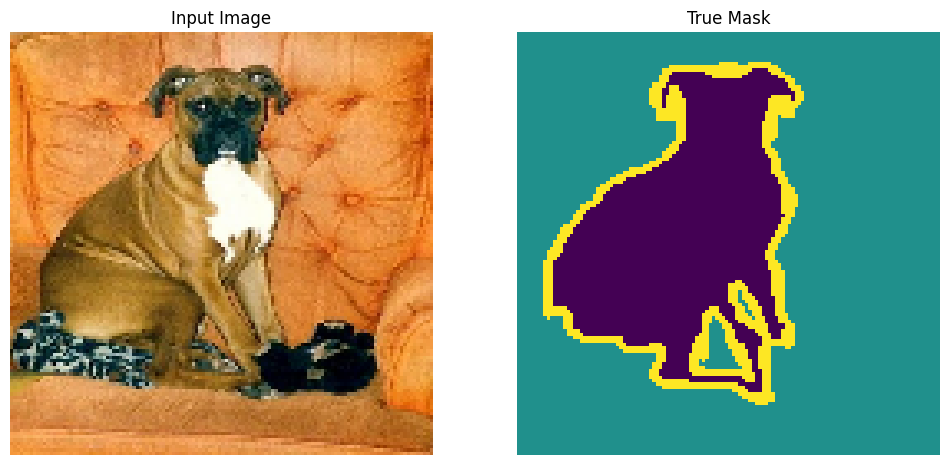

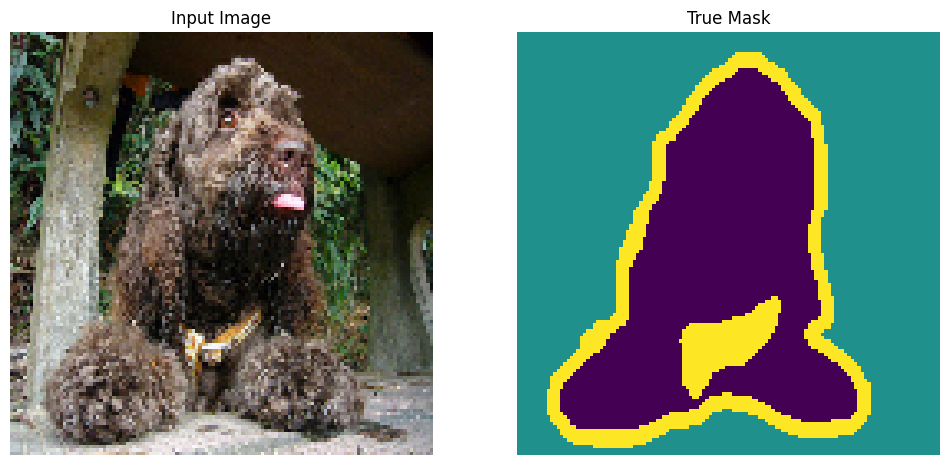

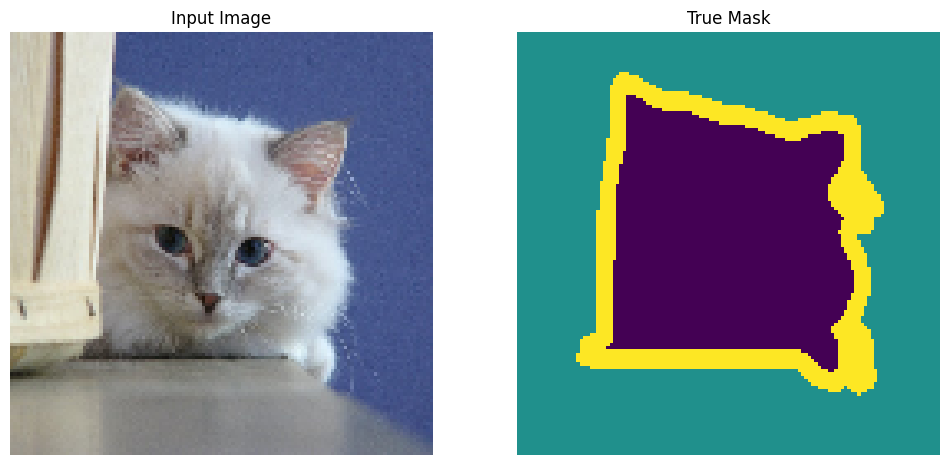

In [14]:
# Randomly select an image and its respective mask 3 times for display
for i in range(3):
  num = np.random.randint(0,3000)
  display([X_train[num],Y_train[num]])

In [15]:
print(f'Shape of X_train: {X_train.shape}\tData type: {type(X_train)}')
print(f'Shape of Y_train: {Y_train.shape}\tData type: {type(Y_train)}')
print(f'Shape of X_val: {X_val.shape}\tData type: {type(X_val)}')
print(f'Shape of Y_val: {Y_val.shape}\tData type: {type(Y_val)}')

Shape of X_train: (6236, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_train: (6236, 128, 128, 1)	Data type: <class 'numpy.ndarray'>
Shape of X_val: (733, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_val: (733, 128, 128, 1)	Data type: <class 'numpy.ndarray'>


In [32]:
# pd.Series(Y_train[i].flatten(order='C')).value_counts().sort_index().index.tolist())
#a = np.array(range(10,22))
#b = np.delete(a,[3,4,5])
#b

array([10, 11, 12, 16, 17, 18, 19, 20, 21])

In [46]:
# identify train masks  that do not have all 3 classifications (0,1,2)
#discard_train_images = []
#for i in range(len(X_train)):
#  if  len(np.unique(Y_train[i])) != 3:
#    print(f'Y_train: {i} is not equal to 3: {np.unique(Y_train[i])}')
#    discard_train_images.append(i)

Y_train: 398 is not equal to 3: [1.]
Y_train: 486 is not equal to 3: [1.]
Y_train: 885 is not equal to 3: [1.]
Y_train: 986 is not equal to 3: [1.]
Y_train: 1076 is not equal to 3: [1.]
Y_train: 1083 is not equal to 3: [1.]
Y_train: 1242 is not equal to 3: [1.]
Y_train: 1833 is not equal to 3: [1.]
Y_train: 2387 is not equal to 3: [1.]
Y_train: 2497 is not equal to 3: [1.]
Y_train: 3609 is not equal to 3: [1.]
Y_train: 3770 is not equal to 3: [1.]


In [48]:
# identify train masks  that do not have all 3 classifications (0,1,2)
# discard_val_images = []
# for i in range(len(X_val)):
#  if  len(np.unique(Y_val[i])) != 3:
#    print(f'Y_val: {i} is not equal to 3: {np.unique(Y_val[i])}')
#    discard_val_images.append(i)

Y_val: 586 is not equal to 3: [1.]


In [51]:
# Delete images and mask where mask does not have all 3 values 
#X_train_f = np.delete(X_train,discard_train_images)
#Y_train_f = np.delete(Y_train,discard_train_images)
#X_val_f = np.delete(X_val,discard_val_images)
#Y_val_f = np.delete(Y_val,discard_val_images)

In [52]:
#print(f'Shape of X_train_f: {X_train_f.shape}\tData type: {type(X_train_f)}')
#print(f'Shape of Y_train_f: {Y_train_f.shape}\tData type: {type(Y_train_f)}')
#print(f'Shape of X_val_f: {X_val_f.shape}\tData type: {type(X_val_f)}')
#print(f'Shape of Y_val_f: {Y_val_f.shape}\tData type: {type(Y_val_f)}')

Shape of X_train_f: (307101684,)	Data type: <class 'numpy.ndarray'>
Shape of Y_train_f: (102367220,)	Data type: <class 'numpy.ndarray'>
Shape of X_val_f: (36077567,)	Data type: <class 'numpy.ndarray'>
Shape of Y_val_f: (12025855,)	Data type: <class 'numpy.ndarray'>


In [31]:
#X_train_f.shape

In [ ]:
class_distribution = []
image_numbers = []
while len(image_numbers) < 1000:
  num = np.random.randint(0,len(Y_train))
  if num not in image_numbers:
    mask_copy = Y_train[num].copy()
    mask = pd.Series(mask_copy.flatten(order='C'))
    if len(mask) == (128*128):
      image_numbers.append(num)
      class_distribution.append([mask.value_counts().sort_index()/(128*128)])
    if len(image_numbers) % 50 == 0:
      print(f'Percent completed: {len(image_numbers)/1000*100}') 



Percent completed: 5.0
Percent completed: 10.0
Percent completed: 15.0
Percent completed: 20.0
Percent completed: 25.0
Percent completed: 30.0
Percent completed: 35.0
Percent completed: 40.0
Percent completed: 45.0
Percent completed: 50.0
Percent completed: 55.00000000000001
Percent completed: 60.0
Percent completed: 65.0
Percent completed: 70.0
Percent completed: 75.0
Percent completed: 80.0
Percent completed: 85.0
Percent completed: 90.0
Percent completed: 95.0
Percent completed: 100.0


In [ ]:
class_0 = 0
class_1 = 0
class_2 = 0
for val in class_distribution:
  if len(val[0].values) == 3:
    class_0 =+ val[0].values[0]
    class_1 =+ val[0].values[1]
    class_2 =+ val[0].values[2]
  

In [ ]:
class_0_distribution = class_0.mean()
class_1_distribution = class_1.mean()
class_2_distribution = class_2.mean()
print(f'Average distribution for class 0: {class_0_distribution}.')
print(f'Average distribution for class 1: {class_1_distribution}.')
print(f'Average distribution for class 2: {class_2_distribution}.')

Average distribution for class 0: 0.368408203125.
Average distribution for class 1: 0.42291259765625.
Average distribution for class 2: 0.20867919921875.


In [16]:
# Convert masks/labels to categorical (onehot encode)
Y_train_cat = to_categorical(Y_train,num_classes=3)
Y_val_cat = to_categorical(Y_val, num_classes=3)


In [17]:
print(f'Y_train_cat.shape: {Y_train_cat.shape}')
print(f'Y_val_cat.shape: {Y_val_cat.shape}')


Y_train_cat.shape: (6236, 128, 128, 3)
Y_val_cat.shape: (733, 128, 128, 3)


In [18]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_p = preprocess_input(X_train.copy())
X_val_p = preprocess_input(X_val.copy())

In [35]:
p_max = X_train_p[1].max()
p_min = X_train_p[1].min()
p_mean = X_train_p[1].mean()
p_median = np.percentile(X_train_p[1],50)
print(f'Mean: {p_mean}\tMedian: {p_median}')
print(f'Min.: {p_min}\t\t\tMax.: {p_max}')

Mean: -16.66971978357434	Median: -29.346867431640618
Min.: -123.68			Max.: 151.061


Image number: 3403


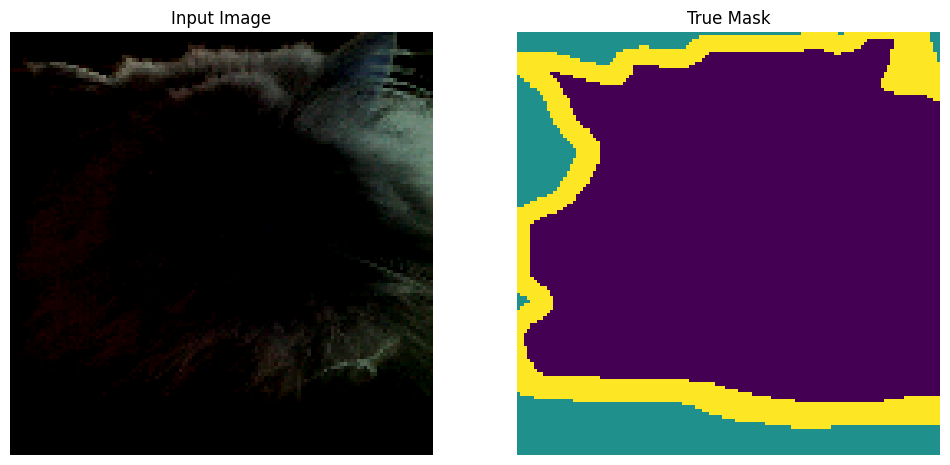

In [28]:
img_num = np.random.randint(0,len(X_train_p))
print(f'Image number: {img_num}')
sample_image, sample_mask = X_train_p[img_num],Y_train[img_num]
display([sample_image,sample_mask])

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = current_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(current_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 20ms/step


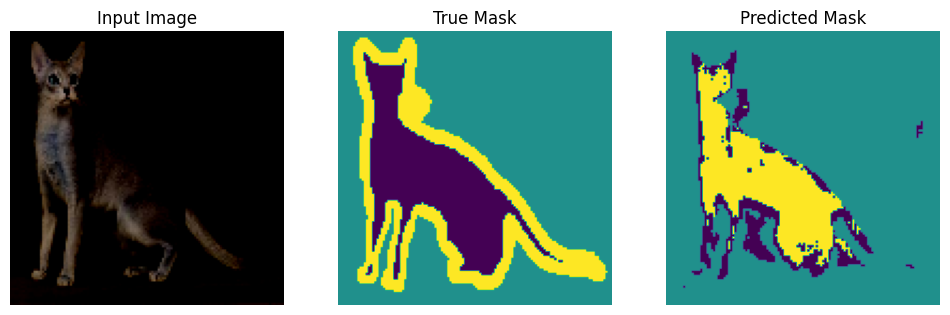

In [ ]:
show_predictions()

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
# define model
n_classes = 3
activation='elu'

model_1a = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1a

In [ ]:
#for idx,layer in enumerate(model.layers):
#  print(f'Layer number: {idx} ==> {layer}')


In [ ]:
LR = 0.0001
optimizer_input_1a = keras.optimizers.Adam(LR)
#optimizer_input = tf.keras.optimizers.SGD(LR)

#loss_input = sm.losses.DiceLoss(class_weights=[0.35,0.5,0.15])
#loss_input = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1*focal_loss)
#loss_input = total_loss
loss_input_1a = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss_input = sm.losses.JaccardLoss(class_weights=[0.35,0.5,0.15])

#metrrics_input = [tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred = False)]
#metrrics_input = ['accuracy']
metrics_input_1a = [tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred = False)]


In [ ]:
model_1.compile(optimizer=optimizer_input_1a,
              loss=loss_input_1a,
              metrics=metrics_input_1a)

In [22]:
earlystopper = EarlyStopping(patience=3, verbose=1)
callback_list = [earlystopper,DisplayCallback()]

In [ ]:
model_1a.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
#tf.keras.utils.plot_model(model_1a, show_shapes=True)
#len(model.layers)

1/1 [==============================] - 0s 23ms/step


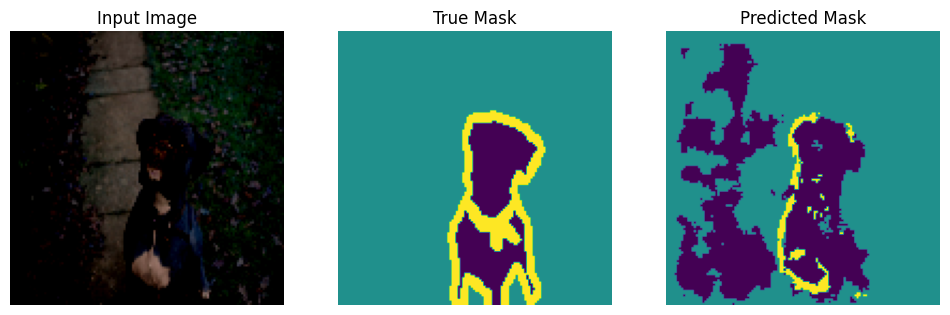


Sample Prediction after epoch 5

60/60 [==============================] - 13s 214ms/step - loss: 0.5569 - mean_io_u_1: 0.5182 - val_loss: 0.5411 - val_mean_io_u_1: 0.5102


In [ ]:
# Pre-train model
history_1a =model_1a.fit(X_train_p, 
            Y_train,
            batch_size=50, 
            epochs=5,
            verbose=1,
            validation_data=(X_val_p,Y_val),
            callbacks=callback_list)

In [ ]:
model_1a.trainable = True

In [ ]:
#model_1a.summary()

1/1 [==============================] - 0s 21ms/step


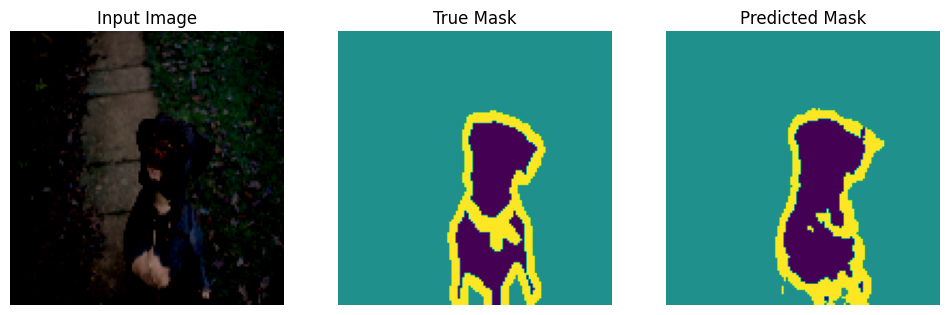


Sample Prediction after epoch 18

60/60 [==============================] - 13s 217ms/step - loss: 0.1724 - mean_io_u_1: 0.7979 - val_loss: 0.2764 - val_mean_io_u_1: 0.7225
Epoch 18: early stopping


In [ ]:
# Train model by fine tunning
history_1a = model_1a.fit(X_train_p, 
             Y_train,
             batch_size=50, 
             epochs=50,
             verbose=1,
             validation_data=(X_val_p,Y_val),
             callbacks=callback_list)

In [ ]:
np.random.seed(123)
test_image_number = np.random.randint(0,len(X_val))
test_img = X_val_p[test_image_number]
ground_truth = Y_val[test_image_number]

test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

test_pred_1a = model_1a.predict(test_img_input)

test_prediction_1a = np.argmax(test_pred_1a, axis=3)[0,:,:]


1/1 [==============================] - 0s 19ms/step


<Figure size 1200x800 with 0 Axes>

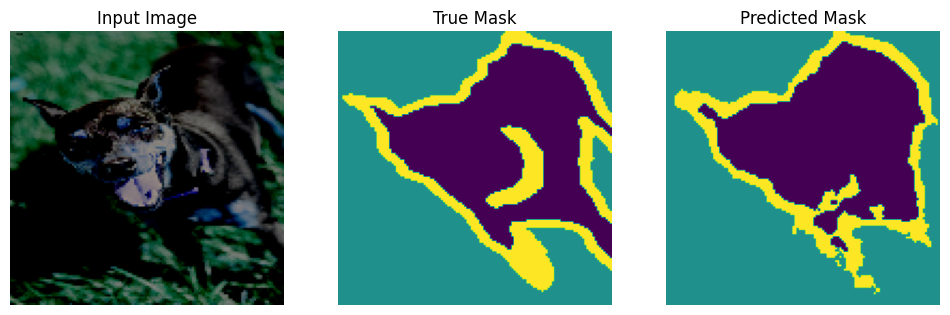

In [ ]:
plt.figure(figsize=(12, 8))
display([test_img,ground_truth,test_prediction_1a])
plt.show()


In [ ]:
history_1a.history.keys()

dict_keys(['loss', 'mean_io_u_1', 'val_loss', 'val_mean_io_u_1'])

In [27]:
def show_history(model_history):
  
  var = list(model_history.history.keys())
  #acc = model_history.history['accuracy']
  #val_acc = model_history.history['val_accuracy']

  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  mean_iou = model_history.history[var[1]]
  val_mean_iou = model_history.history[var[-1]]
  

  epochs_range = model_history.epoch

  plt.figure(figsize=(14, 6))

  #plt.subplot(1,3,1)
  #plt.plot(epochs_range, acc, label='Training Accuracy')
  #plt.plot(epochs_range, val_acc, label='Validation Accuracy')

  #plt.legend(loc='lower right')
  #plt.title('Training and Validation Accuracy')


  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, mean_iou, label='Training MeanIoU')
  plt.plot(epochs_range, val_mean_iou, label='Validation MeanIoU')

  plt.legend(loc='lower right')
  plt.title('Training and Validation IoU')
  plt.show()

  #train_acc = model_history.history['accuracy'][-1]
  #val_acc = model_history.history['val_accuracy'][-1]
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]
  train_meanIoU = model_history.history[var[1]][-1]
  val_meanIoU = model_history.history[var[-1]][-1]

  print(f'Training loss: {train_loss:.3f}\tTraining meanIoU: {train_meanIoU:.3f}')
  print(f'Validation loss: {val_loss:.3f}\tValidation meanIoU: {val_meanIoU:.3f}')
  


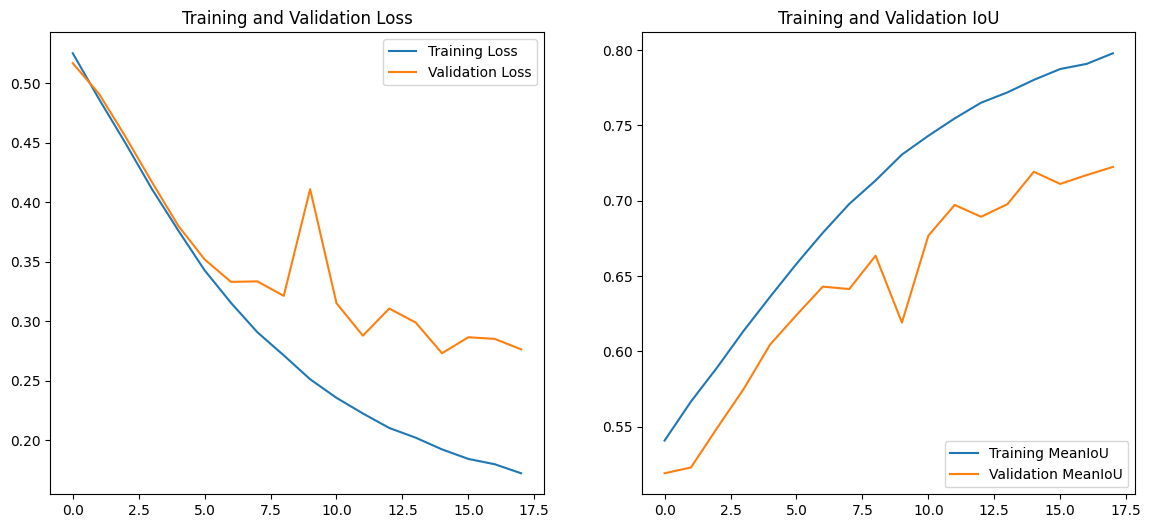

Training loss: 0.172	Training meanIoU: 0.276
Validation loss: 0.276	Validation meanIoU: 0.722


In [ ]:
show_history(history_1a)

In [ ]:
#===============================================================================================

In [ ]:
print(f'X_train_p,shape: {X_train_p.shape}')
print(f'X_val_p,shape: {X_val_p.shape}')

X_train_p,shape: (3000, 128, 128, 3)
X_val_p,shape: (300, 128, 128, 3)


In [41]:
# define model
n_classes = 3
activation='elu'

model_1b = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1b

58889256/58889256 [==============================] - 0s 0us/step


In [42]:
LR_1b = 0.0001
optimizer_input_1b = keras.optimizers.Adam(LR_1b)

loss_input_1b = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metrics_input_1b = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [43]:
model_1b.compile(optimizer=optimizer_input_1b,
              loss=loss_input_1b,
              metrics=metrics_input_1b)

1/1 [==============================] - 0s 22ms/step


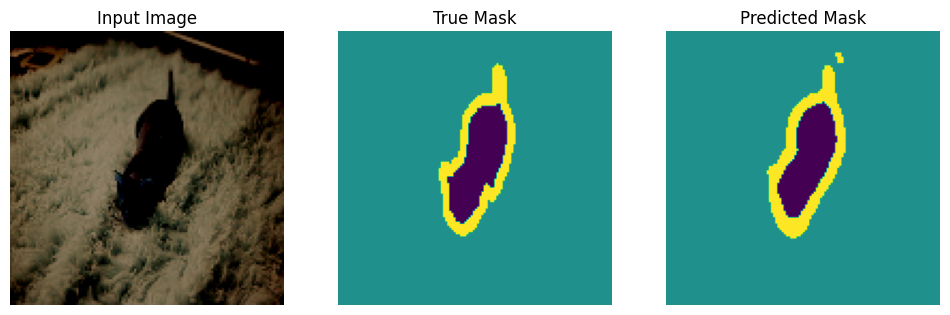


Sample Prediction after epoch 25

125/125 [==============================] - 26s 207ms/step - loss: 0.2703 - mean_io_u: 0.8290 - val_loss: 0.3157 - val_mean_io_u: 0.7519
Epoch 25: early stopping


In [46]:
# Pre-train model
history_1b = model_1b.fit(X_train_p, 
             Y_train_cat,
             batch_size=50, 
             epochs=50,
             verbose=1,
             validation_data=(X_val_p,Y_val_cat),
             callbacks=callback_list)

In [48]:
# Make model encoders trainable for fine tunning
model_1b.trainable = True

In [ ]:
#model_1b.summary()

1/1 [==============================] - 0s 19ms/step


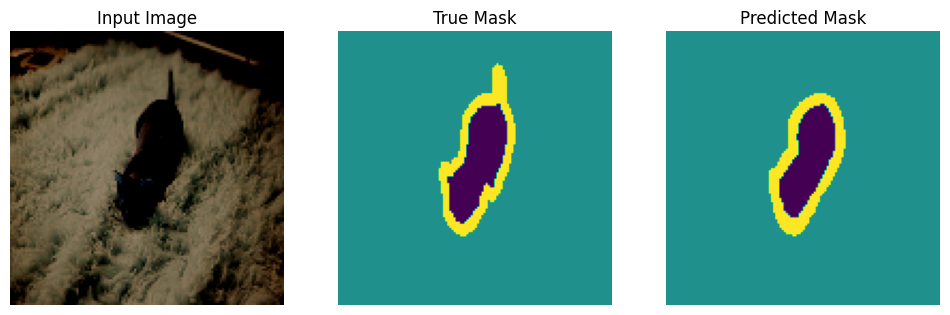


Sample Prediction after epoch 4

125/125 [==============================] - 26s 206ms/step - loss: 0.2666 - mean_io_u: 0.8375 - val_loss: 0.3209 - val_mean_io_u: 0.7449
Epoch 4: early stopping


In [49]:
history_1b=model_1b.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [ ]:
history_1b.history.keys()

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u'])

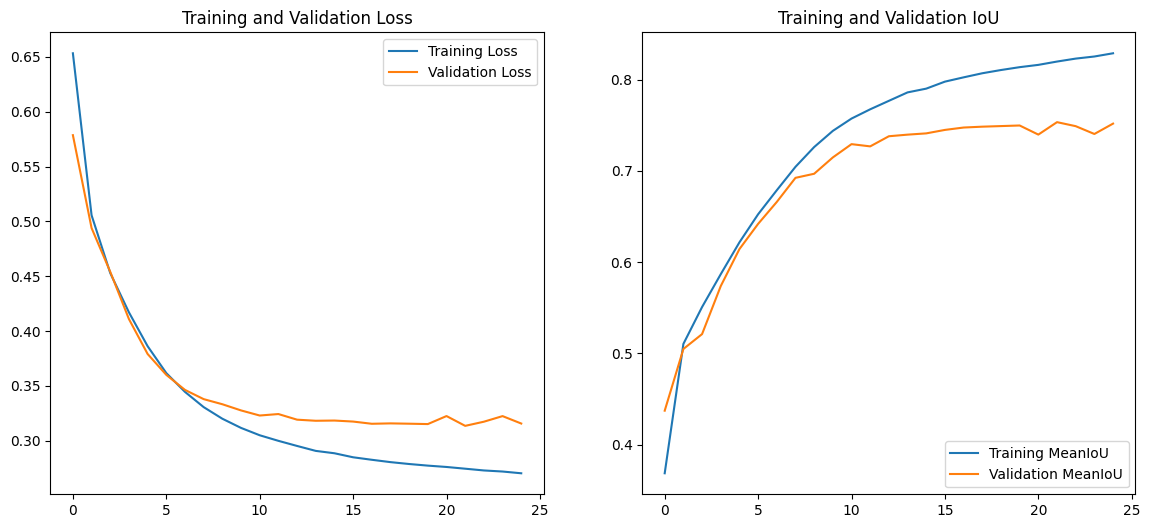

Training loss: 0.270	Training meanIoU: 0.829
Validation loss: 0.316	Validation meanIoU: 0.752


In [47]:
show_history(history_1b)

In [ ]:
#================================================================================================

In [ ]:
# define model
n_classes = 3
activation='softmax'

model_1c = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1c

In [ ]:
LR_1c = 0.0001
optimizer_input_1c = keras.optimizers.Adam(LR_1c)

loss_input_1c = tf.keras.losses.CategoricalCrossentropy()

metrics_input_1c = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_1c.compile(optimizer=optimizer_input_1c,
              loss=loss_input_1c,
              metrics=metrics_input_1c)

In [ ]:
#model_1c.summary()

1/1 [==============================] - 0s 20ms/step


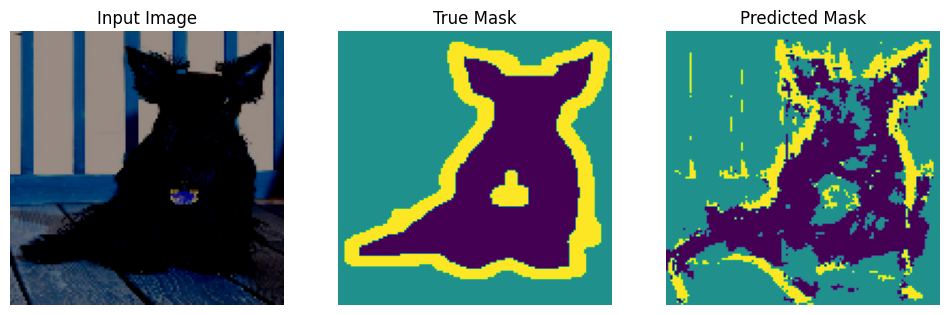


Sample Prediction after epoch 5

60/60 [==============================] - 13s 215ms/step - loss: 0.5676 - mean_io_u_5: 0.5119 - val_loss: 0.5556 - val_mean_io_u_5: 0.5024


In [ ]:
#Pre-train model
history_1c=model_1c.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)


In [ ]:
model_1c.trainable = True

1/1 [==============================] - 0s 22ms/step


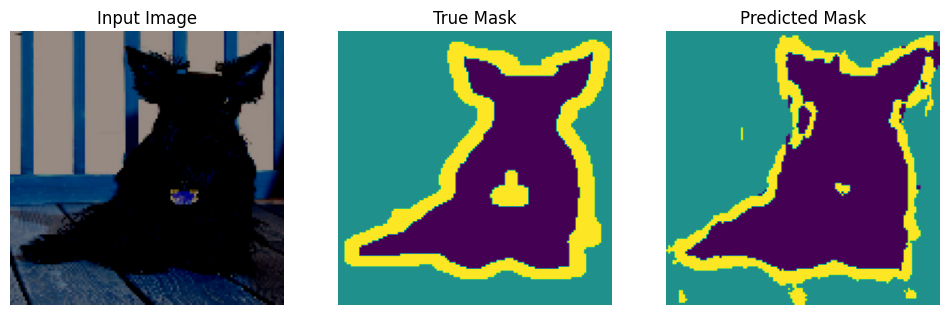


Sample Prediction after epoch 20

60/60 [==============================] - 13s 216ms/step - loss: 0.1650 - mean_io_u_5: 0.8009 - val_loss: 0.3291 - val_mean_io_u_5: 0.6973
Epoch 20: early stopping


In [ ]:
# Train and fine-tune model
history_1c=model_1c.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)


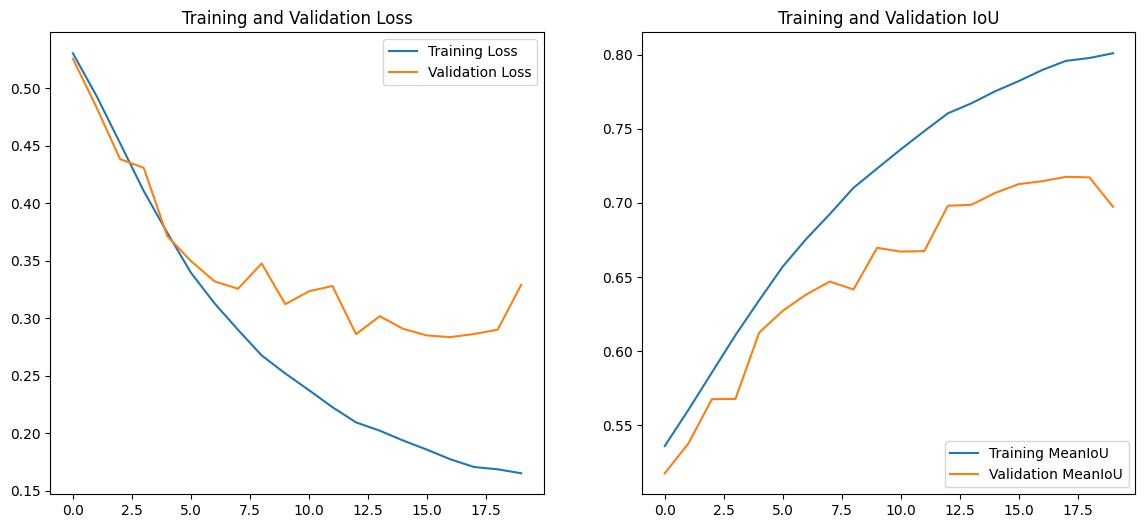

Training loss: 0.165	Training meanIoU: 0.801
Validation loss: 0.329	Validation meanIoU: 0.697


In [ ]:
show_history(history_1c)


In [ ]:
#=============================================================================================

In [50]:
# define model
n_classes = 3
activation='softmax'

model_1d = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1d

In [52]:
LR_1d = 0.0001
optimizer_input_1d = keras.optimizers.Adam(LR_1d)

loss_input_1d = sm.losses.DiceLoss()

metrics_input_1d = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [53]:
model_1d.compile(optimizer=optimizer_input_1d,
              loss=loss_input_1d,
              metrics=metrics_input_1d)

In [ ]:
#model_1d.summary()

1/1 [==============================] - 0s 19ms/step


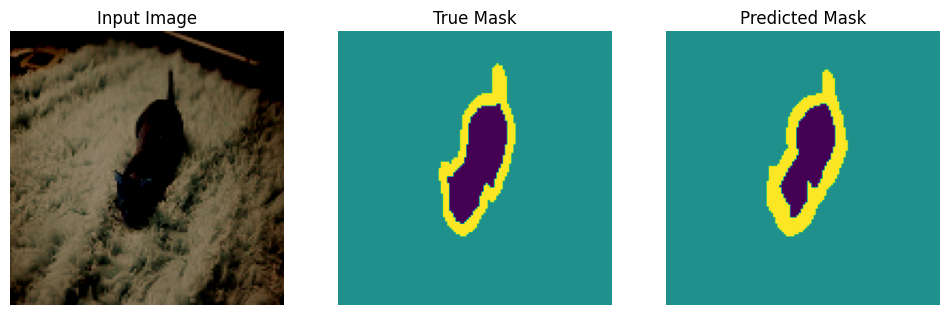


Sample Prediction after epoch 15

125/125 [==============================] - 26s 209ms/step - loss: 0.1244 - mean_io_u_1: 0.7993 - val_loss: 0.1609 - val_mean_io_u_1: 0.7459
Epoch 15: early stopping


In [54]:
#Pre-train model
history_1d=model_1d.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [56]:
model_1d.trainable = True

1/1 [==============================] - 0s 23ms/step


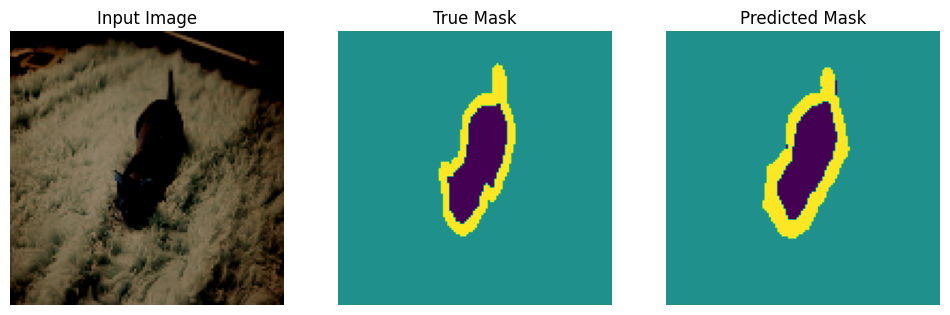


Sample Prediction after epoch 4

125/125 [==============================] - 26s 207ms/step - loss: 0.1130 - mean_io_u_1: 0.8144 - val_loss: 0.1535 - val_mean_io_u_1: 0.7554
Epoch 4: early stopping


In [57]:
#Train model
history_1d=model_1d.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

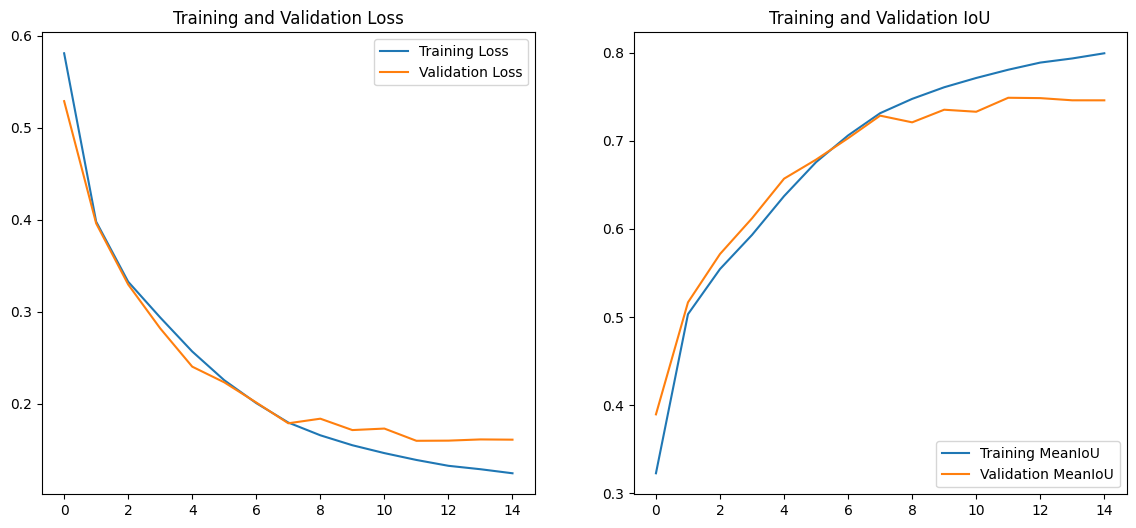

Training loss: 0.124	Training meanIoU: 0.799
Validation loss: 0.161	Validation meanIoU: 0.746


In [55]:
show_history(history_1d)

In [ ]:
#=================================================================================================

In [ ]:
# define model
n_classes = 3
activation='softmax'

model_1e = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1e

In [ ]:
LR_1e = 0.0001
optimizer_input_1e = keras.optimizers.Adam(LR_1e)

loss_input_1e = sm.losses.DiceLoss(class_weights=[0.45,0.45,0.1])

metrics_input_1e = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_1e.compile(optimizer=optimizer_input_1e,
              loss=loss_input_1e,
              metrics=metrics_input_1e)

1/1 [==============================] - 0s 20ms/step


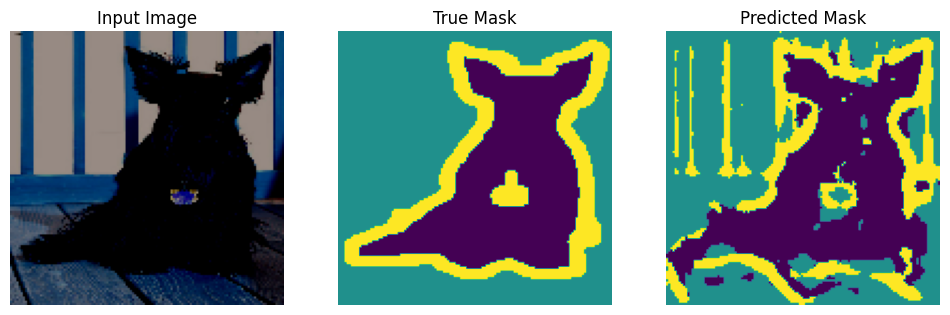


Sample Prediction after epoch 5

60/60 [==============================] - 13s 214ms/step - loss: 0.7588 - mean_io_u_14: 0.5296 - val_loss: 0.7631 - val_mean_io_u_14: 0.5224


In [ ]:
#Pre-train model
history_1e=model_1e.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [ ]:
model_1e.trainable = True

1/1 [==============================] - 0s 19ms/step


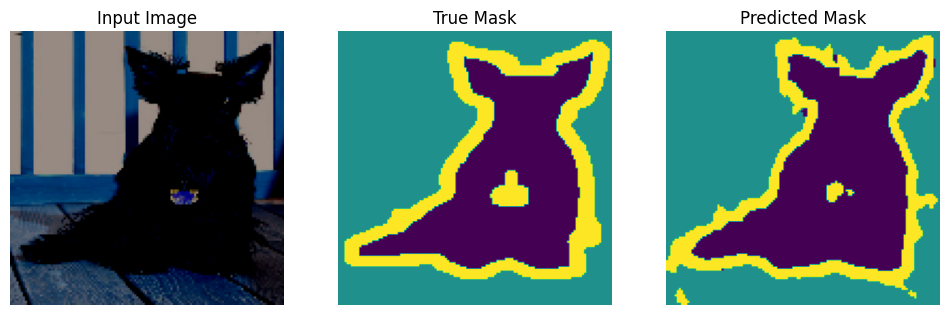


Sample Prediction after epoch 26

60/60 [==============================] - 13s 216ms/step - loss: 0.6886 - mean_io_u_14: 0.8100 - val_loss: 0.7042 - val_mean_io_u_14: 0.7140
Epoch 26: early stopping


In [ ]:
#Pre-train model
history_1e=model_1e.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

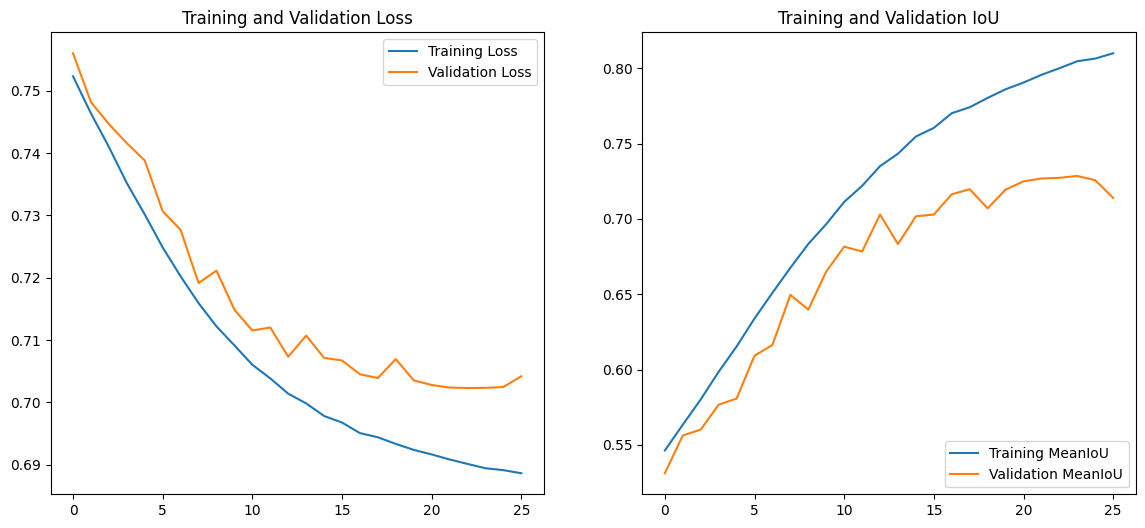

Training loss: 0.689	Training meanIoU: 0.810
Validation loss: 0.704	Validation meanIoU: 0.714


In [ ]:
show_history(history_1e)

In [ ]:
#==============================================================================================

In [29]:
# define model
n_classes = 3
activation='softmax'

model_1f = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1f

In [30]:
LR_1f = 0.0001
optimizer_input_1f = keras.optimizers.Adam(LR_1f)

loss_input_1f = sm.losses.JaccardLoss()

metrics_input_1f = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [31]:
model_1f.compile(optimizer=optimizer_input_1f,
              loss=loss_input_1f,
              metrics=metrics_input_1f)

1/1 [==============================] - 0s 21ms/step


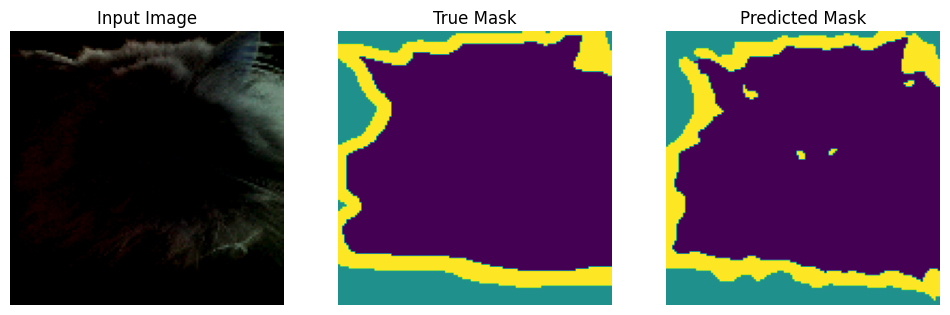


Sample Prediction after epoch 15

250/250 [==============================] - 28s 111ms/step - loss: 0.1912 - mean_io_u_1: 0.8110 - val_loss: 0.2758 - val_mean_io_u_1: 0.7266
Epoch 15: early stopping


In [32]:
#Pre-train model
history_1f=model_1f.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=25, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [33]:
model_1f.trainable = True

1/1 [==============================] - 0s 21ms/step


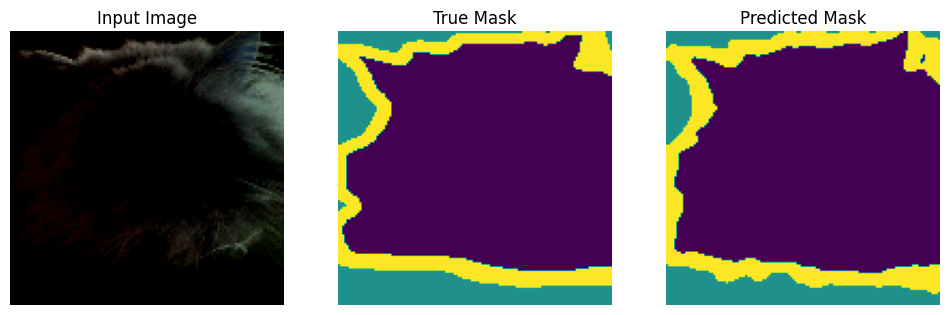


Sample Prediction after epoch 4

250/250 [==============================] - 28s 111ms/step - loss: 0.1793 - mean_io_u_1: 0.8226 - val_loss: 0.2397 - val_mean_io_u_1: 0.7619
Epoch 4: early stopping


In [34]:
# Train model
history_1f=model_1f.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=25, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

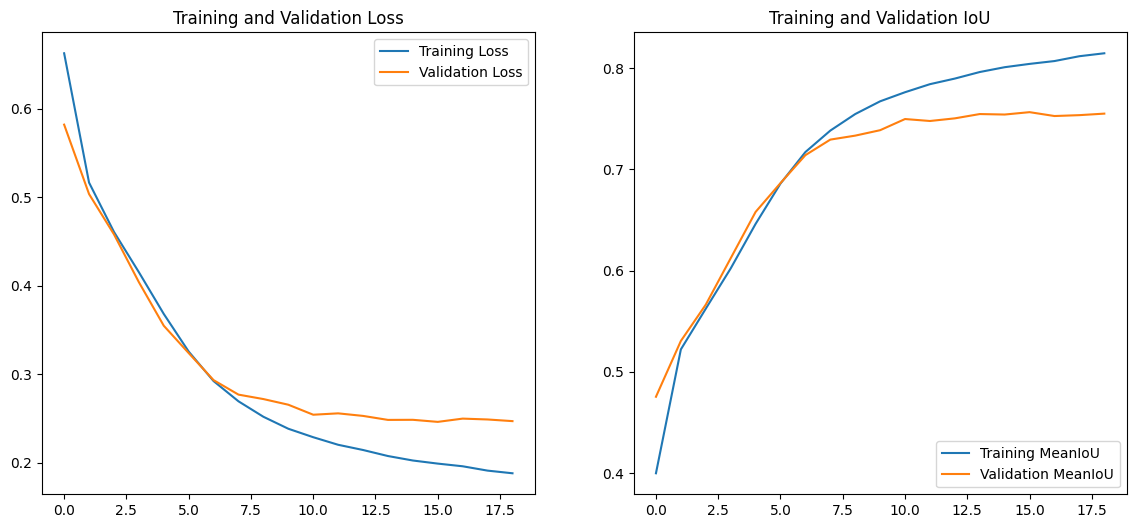

Training loss: 0.188	Training meanIoU: 0.815
Validation loss: 0.247	Validation meanIoU: 0.755


In [63]:
show_history(history_1f)

In [ ]:
#==========================================================================================

In [ ]:
#Pre-train model
history_1g=model_1g.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [ ]:
LR_1g = 0.0001
optimizer_input_1g = keras.optimizers.Adam(LR_1g)

loss_input_1g = sm.losses.CategoricalCELoss()

metrics_input_1g = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_1g.compile(optimizer=optimizer_input_1g,
              loss=loss_input_1g,
              metrics=metrics_input_1g)

1/1 [==============================] - 0s 20ms/step


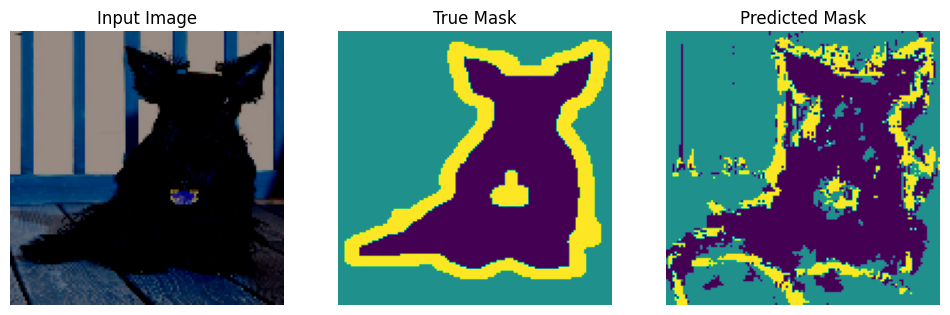


Sample Prediction after epoch 5

60/60 [==============================] - 13s 220ms/step - loss: 0.2132 - mean_io_u_17: 0.5039 - val_loss: 0.2111 - val_mean_io_u_17: 0.4870


In [ ]:
#Pre-rain model
history_1g=model_1g.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [ ]:
model_1g.trainable = True

In [ ]:
#=========================================================================================

In [ ]:
# define model
n_classes = 3
activation='softmax'

model_1h = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1h

In [ ]:
LR_1h = 0.0001
optimizer_input_1h = keras.optimizers.Adam(LR_1h)

loss_input_1h = sm.losses.CategoricalFocalLoss()

metrics_input_1h = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_1h.compile(optimizer=optimizer_input_1h,
              loss=loss_input_1h,
              metrics=metrics_input_1h)

1/1 [==============================] - 0s 21ms/step


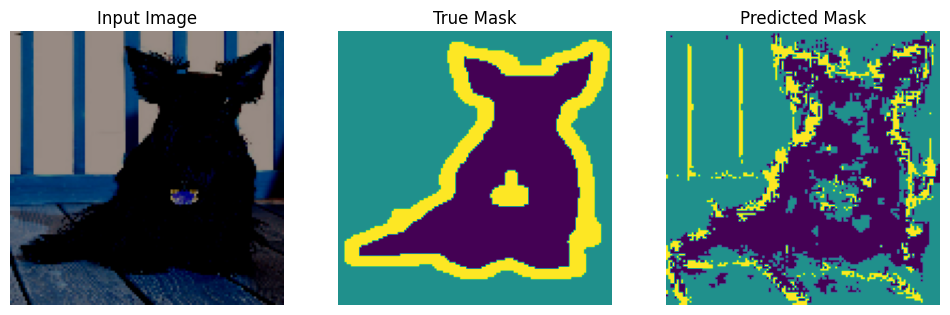


Sample Prediction after epoch 5

60/60 [==============================] - 13s 219ms/step - loss: 0.0223 - mean_io_u_18: 0.4781 - val_loss: 0.0219 - val_mean_io_u_18: 0.4714


In [ ]:
#Pre-train model
history_1h=model_1h.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [ ]:
model_1h.trainable = True

1/1 [==============================] - 0s 21ms/step


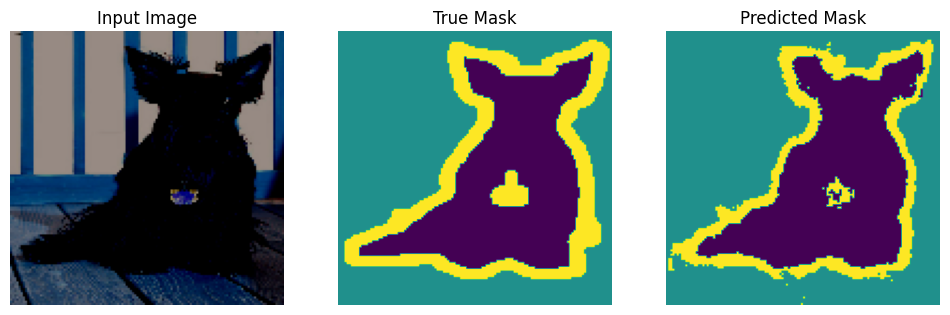


Sample Prediction after epoch 29

60/60 [==============================] - 13s 218ms/step - loss: 0.0051 - mean_io_u_18: 0.7818 - val_loss: 0.0093 - val_mean_io_u_18: 0.7160
Epoch 29: early stopping


In [ ]:
history_1h=model_1h.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

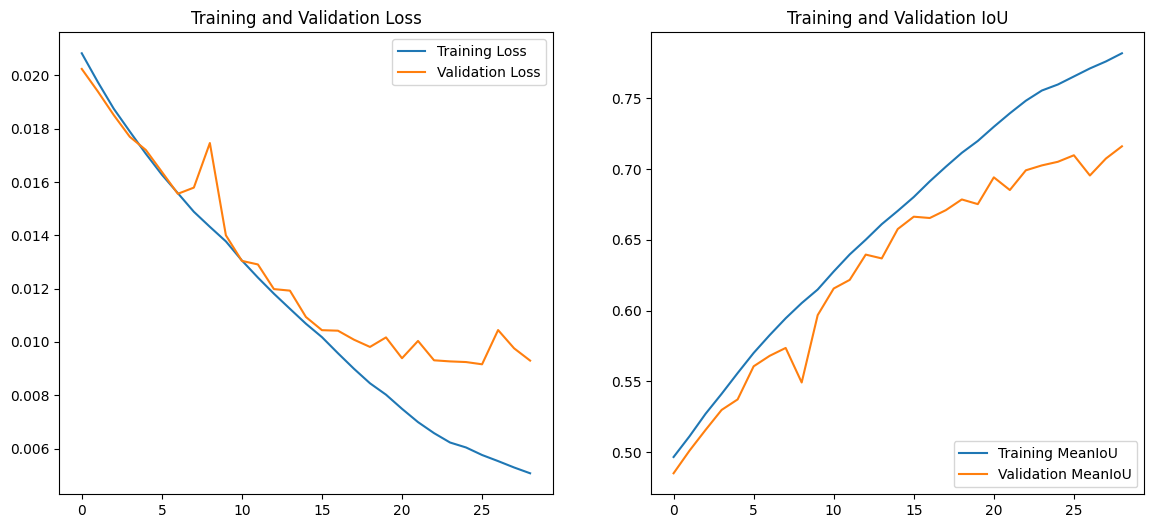

Training loss: 0.005	Training meanIoU: 0.782
Validation loss: 0.009	Validation meanIoU: 0.716


In [ ]:
show_history(history_1h)

In [ ]:
#=============================================================================================

In [ ]:
# define model
n_classes = 3
activation='softmax'

model_1i = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1i

In [ ]:
LR_1i = 0.0001
optimizer_input_1i = keras.optimizers.Adam(LR_1i)

loss_input_1i = sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss() + sm.losses.CategoricalCELoss()

metrics_input_1i = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_1i.compile(optimizer=optimizer_input_1i,
              loss=loss_input_1i,
              metrics=metrics_input_1i)

1/1 [==============================] - 0s 19ms/step


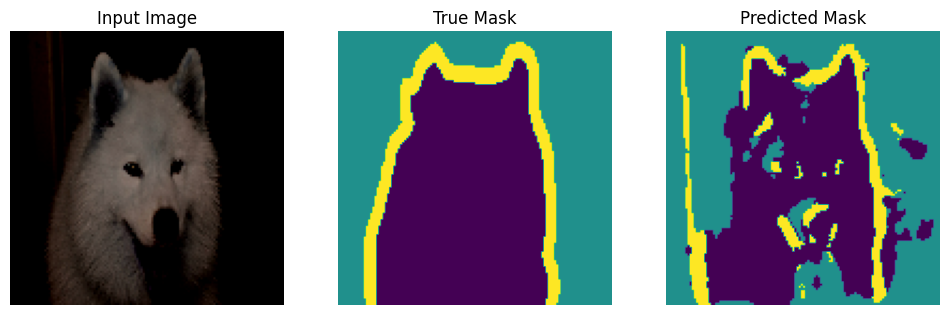


Sample Prediction after epoch 5

60/60 [==============================] - 13s 210ms/step - loss: 0.6067 - mean_io_u_1: 0.5469 - val_loss: 0.6169 - val_mean_io_u_1: 0.5382


In [ ]:
#Pre-train model
history_1i=model_1i.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [ ]:
model_1i.trainable = True

1/1 [==============================] - 0s 20ms/step


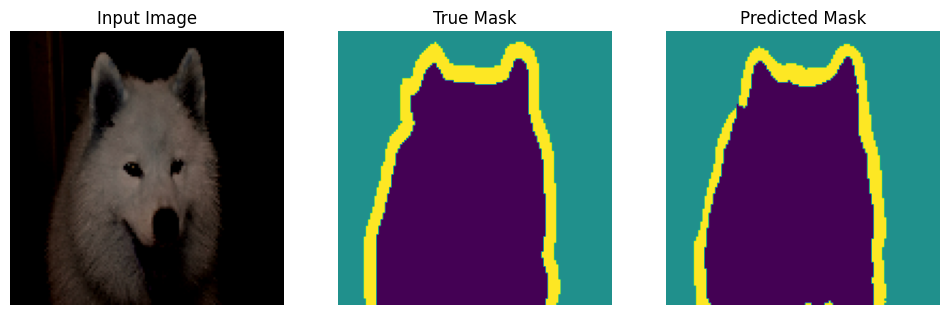


Sample Prediction after epoch 22

60/60 [==============================] - 13s 212ms/step - loss: 0.1938 - mean_io_u_1: 0.8198 - val_loss: 0.3257 - val_mean_io_u_1: 0.7288
Epoch 22: early stopping


In [ ]:
#train model
history_1i=model_1i.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)

In [ ]:
# define model
n_classes = 3
activation='softmax'

model_1j = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                activation=activation,classes=n_classes,
                input_shape=(img_height,img_width,3),
                encoder_freeze=True)

current_model = model_1j

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
LR_1j = 0.001
optimizer_input_1j = keras.optimizers.experimental.SGD(learning_rate=LR_1j)

loss_input_1j = sm.losses.JaccardLoss()

metrics_input_1j = [tf.keras.metrics.MeanIoU(num_classes=3,
                                             sparse_y_pred = False,
                                             sparse_y_true=False)]

In [ ]:
model_1j.compile(optimizer=optimizer_input_1j,
              loss=loss_input_1j,
              metrics=metrics_input_1j)

1/1 [==============================] - 0s 20ms/step


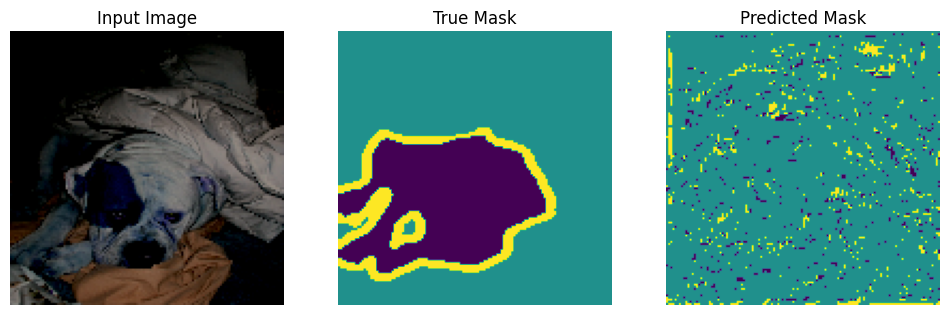


Sample Prediction after epoch 5

60/60 [==============================] - 12s 200ms/step - loss: 0.7933 - mean_io_u: 0.2096 - val_loss: 0.7954 - val_mean_io_u: 0.2143


In [ ]:
#Pre-train model
history_1j=model_1j.fit(X_train_p, 
                    Y_train_cat,
                    batch_size=50, 
                    epochs=5,
                    verbose=1,
                    validation_data=(X_val_p,Y_val_cat),
                    callbacks=callback_list)